In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense
from sklearn.model_selection import train_test_split

In [2]:
# Đọc dữ liệu từ file CSV và gắn index với giá Close
df = pd.read_csv('C:\\Users\\Admin\\Downloads\\ACB.csv')
df1=df.reset_index()['Close']
df1 = df[['Close']]

In [3]:
# 3. Scaler data
df1['Close'] = df1['Close'].str.replace(',', '')
df1['Close'] = df1['Close'].astype(float)
scaler = MinMaxScaler(feature_range=(0, 1))
df1 = scaler.fit_transform(df1.values.reshape(-1, 1))

C:\Users\Admin\AppData\Local\Temp\ipykernel_3656\811875966.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['Close'] = df1['Close'].str.replace(',', '')
C:\Users\Admin\AppData\Local\Temp\ipykernel_3656\811875966.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['Close'] = df1['Close'].astype(float)


In [4]:
#4. Chia thành tập train, validation và test
train_size = int(0.8 * len(df1))
test_size = int(0.2 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

In [5]:
#5 Hàm tạo dataset
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [6]:
# Reshape into X=t,t+1,t+2..t+99 and Y=t+100
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [7]:
# Reshape input to be [samples, time steps, features] which is required for GRU
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [8]:
def create_gru_model(input_shape):
    model = create_gru_model(input_shape=X_train.shape[1])
    model = Sequential()
    model.add(GRU(50, return_sequences=True, input_shape=(100, 1)))
    model.add(GRU(50, return_sequences=True))
    model.add(GRU(50))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

In [9]:
# Hàm Bagging cho GRU
def bagging_gru(train_data, test_data, n_models=5):
    predictions = np.zeros(len(test_data))

    for _ in range(n_models):
        # Tạo mô hình GRU mới cho mỗi lần lặp
        model = create_gru_model(input_shape=train_data.shape[1])

        # Huấn luyện mô hình
        model.fit(X_train, y_train, epochs=100, batch_size=64, verbose=0)

        # Dự đoán trên tập kiểm tra
        y_pred = model.predict(test_data)

        # Thêm dự đoán của mô hình vào tổng quan
        predictions += y_pred.flatten()

    # Trung bình dự đoán của các mô hình
    predictions /= n_models

    return predictions

In [10]:
# Mô hình Bagging GRU
bagged_predictions = bagging_gru(X_train, X_test, n_models=5)

RecursionError: maximum recursion depth exceeded

In [ ]:
# Đánh giá mô hình
rmse = np.sqrt(mean_squared_error(y_test, bagged_predictions))
mape = mean_absolute_percentage_error(y_test, bagged_predictions)
mae = mean_absolute_error(y_test, bagged_predictions)
mse = mean_squared_error(y_test, bagged_predictions)

# In kết quả
print(f"RMSE: {rmse}")
print(f"MAPE: {mape}")
print(f"MAE: {mae}")
print(f"MSE: {mse}")

RMSE: 0.008630322384042495
MAPE: 0.051161278510928956
MAE: 0.006395849301881256
MSE: 7.448246445250495e-05


In [ ]:
test_data.shape

(298, 1)

In [ ]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)
#y_pred_val=model.predict(X_val)

NameError: name 'model' is not defined

In [ ]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred = scaler.inverse_transform(y_pred)
#y_pred_val=scaler.inverse_transform(y_pred_val)

NameError: name 'train_predict' is not defined

In [ ]:
# 13. Dự báo 30 ngày tiếp theo
x_input=test_data[152:].reshape(1,-1)
x_input.shape
        
temp_input=list(x_input)
temp_input=temp_input[0].tolist()
    
from numpy import array
        
lst_output=[]
n_steps=145
i=0
while(i<30):
            
    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        n_steps = min(len(temp_input), 100)
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1

NameError: name 'test_data' is not defined

ValueError: x and y must have same first dimension, but have shapes (448,) and (298, 1)

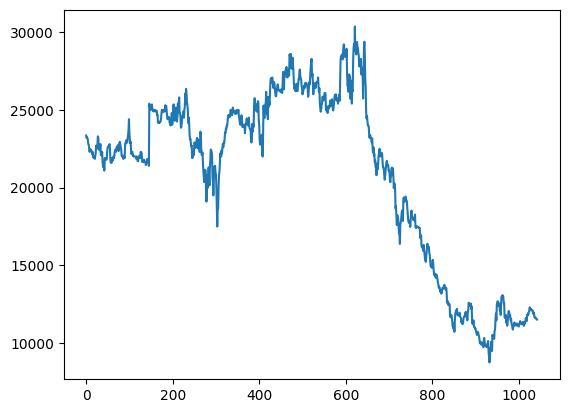

In [ ]:
#Vẽ hình
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=len(df1), step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+101, stop=len(df1), step=1)
plt.plot(test_data_index,(y_pred))
#val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
#plt.plot(val_data_index,scaler.inverse_transform(val_data))
#val_data_index = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
#plt.plot(val_data_index,y_pred_val)
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Predict','Predict30days'])
plt.show()